# Plot Paloma data

## Imports and setup

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import wandb

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)


def format_ticks(x, pos):
    return str(int(x // 1000))


wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yw580 (pico-lm). Use `wandb login --relogin` to force relogin


True

## Get data from runs

In [5]:
api = wandb.Api()

RUN_SCALE = "tiny"

runs = [
    api.run("pico-lm/pico-decoder/lne20rc1"),  # pico decoder tiny
    api.run("pico-lm/pico-relora/6vhmv4aj"),  # pico relora tiny
    api.run("pico-lm/pico-decoder/kzcalg17"),  # small
    api.run("pico-lm/pico-relora/5urfvs2j"),
]

dfs = []

for ridx, run in enumerate(runs):
    df = pd.DataFrame(run.scan_history())
    df["Model"] = rf"\texttt{{pico-{'decoder' if ridx % 2 == 0 else 'relora'}}}"
    df["Scale"] = "tiny" if ridx < 2 else "small"
    dfs.append(df)

run_data = pd.concat(dfs, ignore_index=True)

In [68]:
# filter run data
f_run_data = run_data[run_data["eval/paloma"].notna() | run_data["train/loss"].notna()]

loss_data = (
    f_run_data[["trainer/global_step", "train/loss", "Model", "Scale"]]
    .dropna()
    .rename(columns={"train/loss": "Value"})
)
loss_data["Metric"] = "Loss"

ppl_data = (
    f_run_data[["trainer/global_step", "eval/paloma", "Model", "Scale"]]
    .dropna()
    .rename(columns={"eval/paloma": "Value"})
)
ppl_data["Metric"] = "PPL"

# Concatenate the dataframes
combined_data = pd.concat([loss_data, ppl_data], ignore_index=True)
combined_data = combined_data[combined_data["trainer/global_step"] <= 20_000]
# combined_data = combined_data[combined_data["trainer/global_step"] % 1_000 == 0]

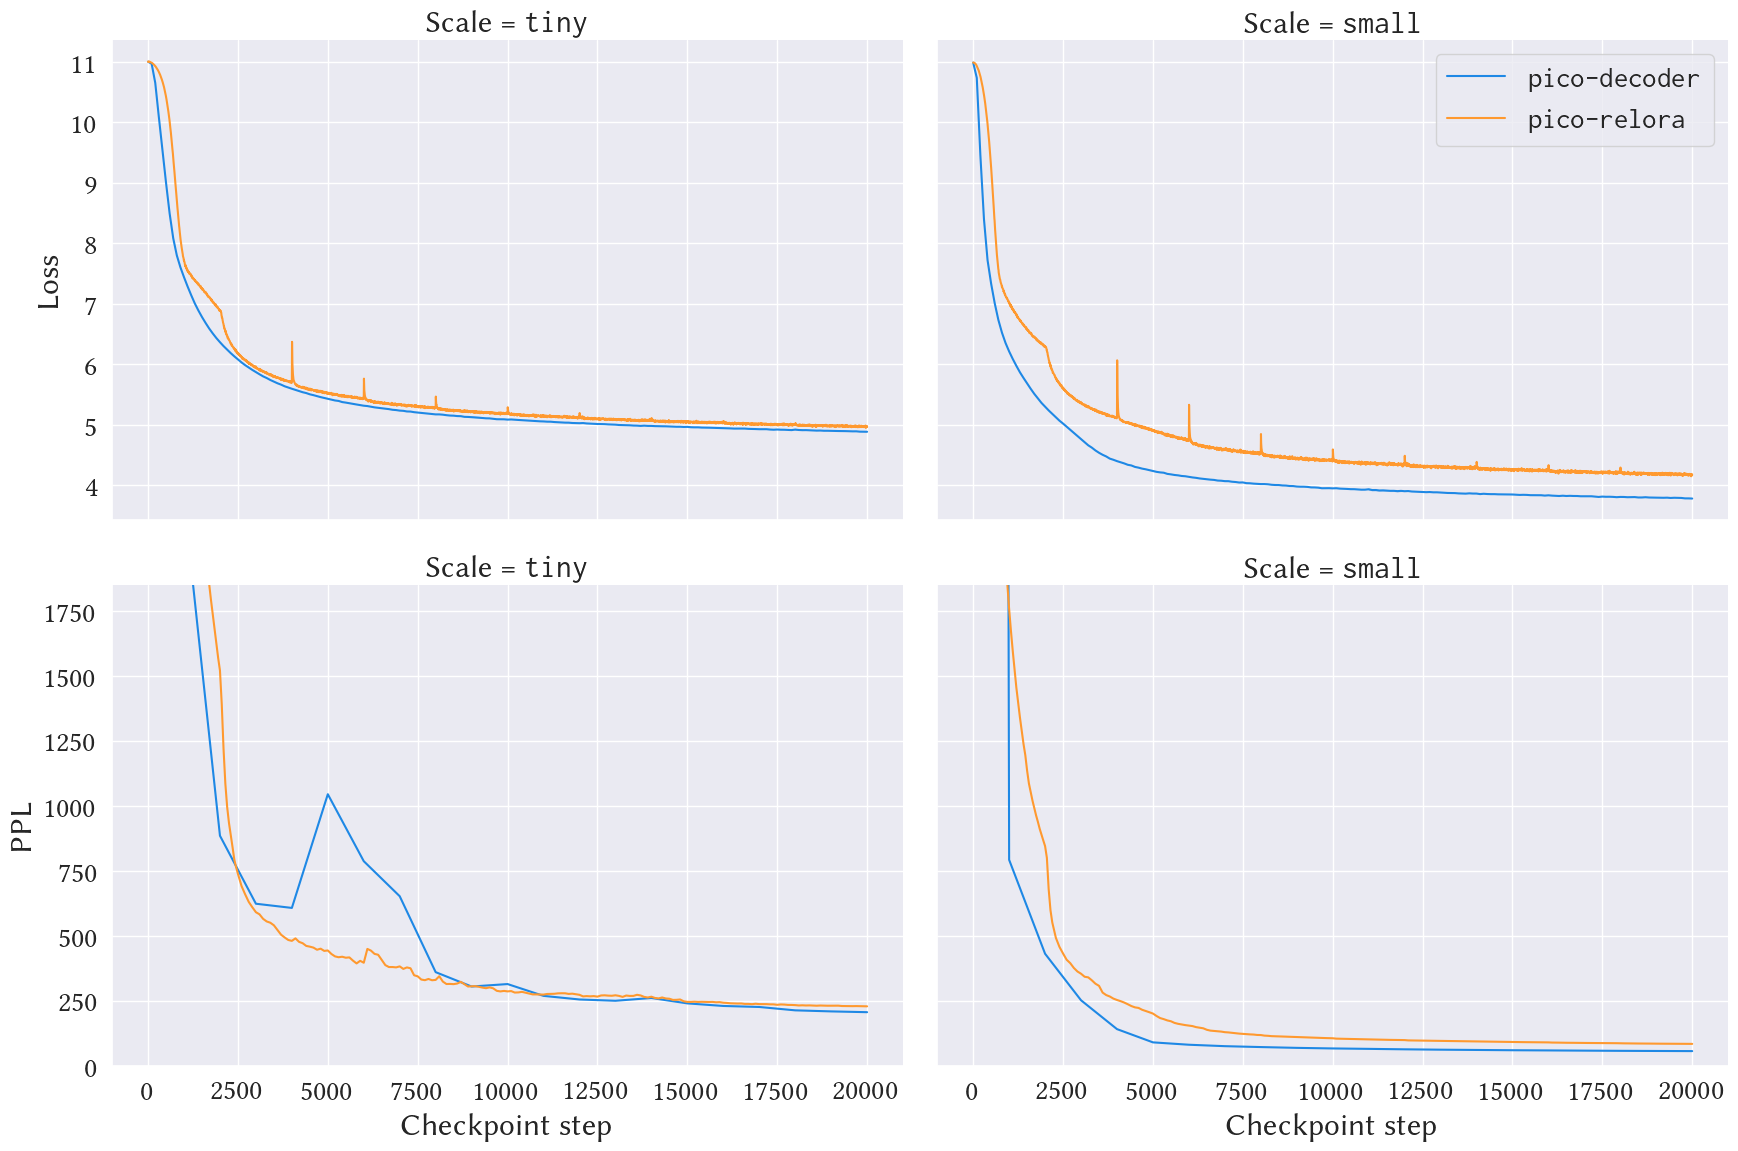

In [69]:
colors = ["#1E88E5", "#FF992F"]
models = sorted(combined_data["Model"].unique().tolist())
palette = dict(zip(models, colors))

dodge = 0.4
size = 8
font_scale = 1.9

sns.set_theme(font_scale=font_scale, rc={"axes.grid": "True", "axes.grid.which": "both"})

g = sns.FacetGrid(
    data=combined_data,
    col="Scale",
    row="Metric",
    height=6,
    aspect=1.5,
    sharey="row",
    sharex=True,
    margin_titles=False,
)

g.map_dataframe(sns.lineplot, x="trainer/global_step", y="Value", hue="Model", palette=palette)


for i, ax_row in enumerate(g.axes):
    for ax in ax_row:
        if i == 0:  # First row (Loss)
            ax.set_ylabel("Loss")
        else:  # Second row (PPL)
            ax.set_ylabel("PPL")

        if "tiny" in ax.get_title().lower():
            ax.set_title(r"Scale = \texttt{tiny}")
        elif "small" in ax.get_title().lower():
            ax.set_title(r"Scale = \texttt{small}")

for axid, ax in enumerate(g.axes.flat):
    if axid > 1:
        ax.set_ylim(0, 1850)
    elif axid == 1:
        ax.legend(bbox_to_anchor=(1, 1), loc="upper right")


g.set_axis_labels("Checkpoint step")

plt.savefig("../graphs/training-per-step.pdf")
plt.show()